In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.gen_model import OTFlowMatching, MLP_FM_VAE2, MLP_no_noise, Bridge_MLP

2023-07-25 07:35:22.497210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from moscot import datasets
adata_atac = datasets.bone_marrow(rna=False)
adata_rna = datasets.bone_marrow(rna=True)

In [4]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"][:,:-1], norm="l2"
)


/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


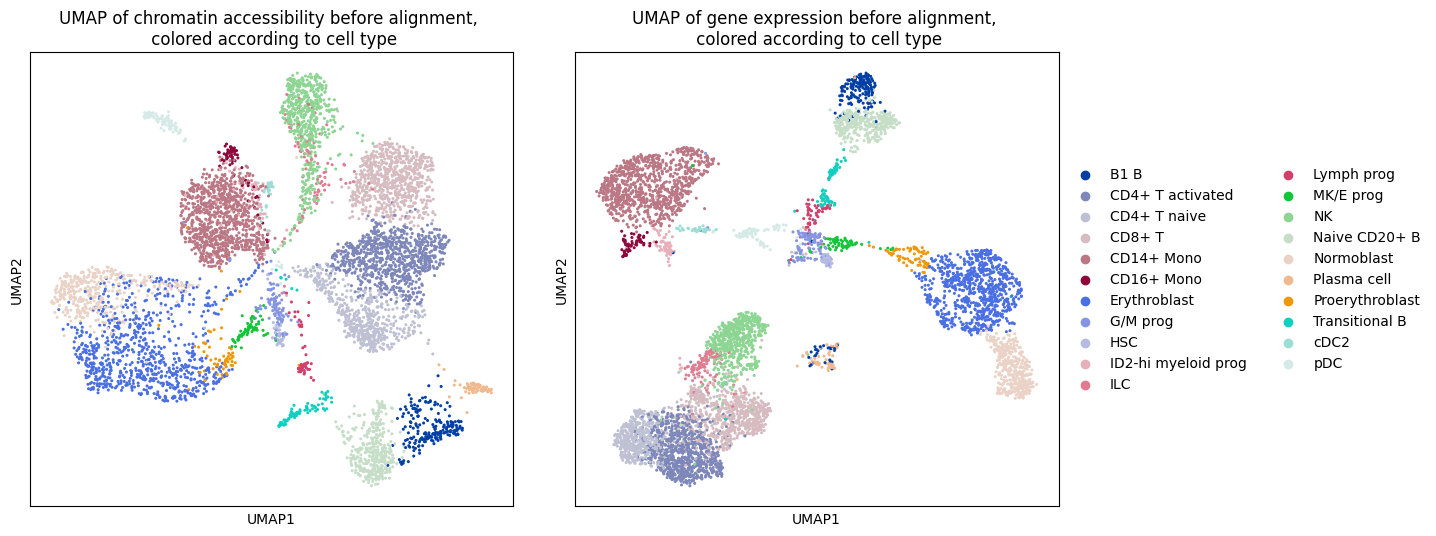

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [6]:
source = adata_atac.obsm["ATAC_lsi_l2_norm"]
target = adata_rna.obsm["GEX_X_pca"]

In [7]:
source_red = sc.pp.pca(source, n_comps=10)
target_red = sc.pp.pca(target, n_comps=10)

In [8]:
from ott.solvers.linear import acceleration

neural_net = MLP_FM_VAE2(10, 64, 64, 64)
bridge_net = Bridge_MLP(10, 32, 32)
linear_ot_solver = sinkhorn.Sinkhorn(
            momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=1e-2, linear_ot_solver=linear_ot_solver)

#cosine_decay_scheduler = optax.cosine_decay_schedule(1e-4, decay_steps=2e5, alpha=0.95)
#optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
otfm = OTFlowMatching(neural_net, bridge_net, input_dim=10, output_dim=10, iterations=10_000, ot_solver=solver, k_noise_per_x=10, noise_std=1.0)

In [9]:
# to check: is it because of sig_min, or because of sigma=1.0 or because of k_samples_per_x=1
otfm.iterations = 100_000 
otfm(source_red, target_red, 800, 800)

2023-07-25 07:36:04.115011: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
 19%|█▉        | 18994/100000 [21:30<1:31:41, 14.72it/s]


KeyboardInterrupt: 

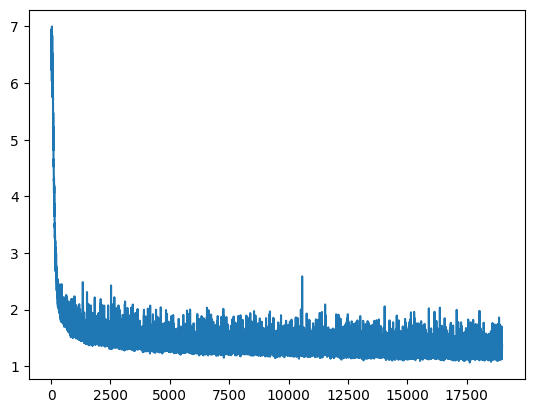

In [10]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

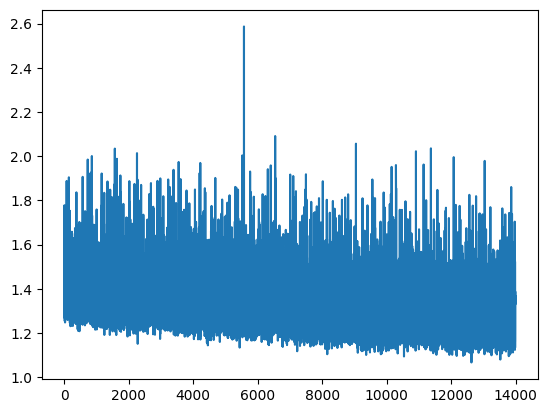

In [11]:
plt.plot(np.arange(len(otfm.metrics["loss"][5000:])), otfm.metrics["loss"][5000:])

In [13]:
gex_predicted,_, _ = otfm.transport(source_red, seed=0)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in N

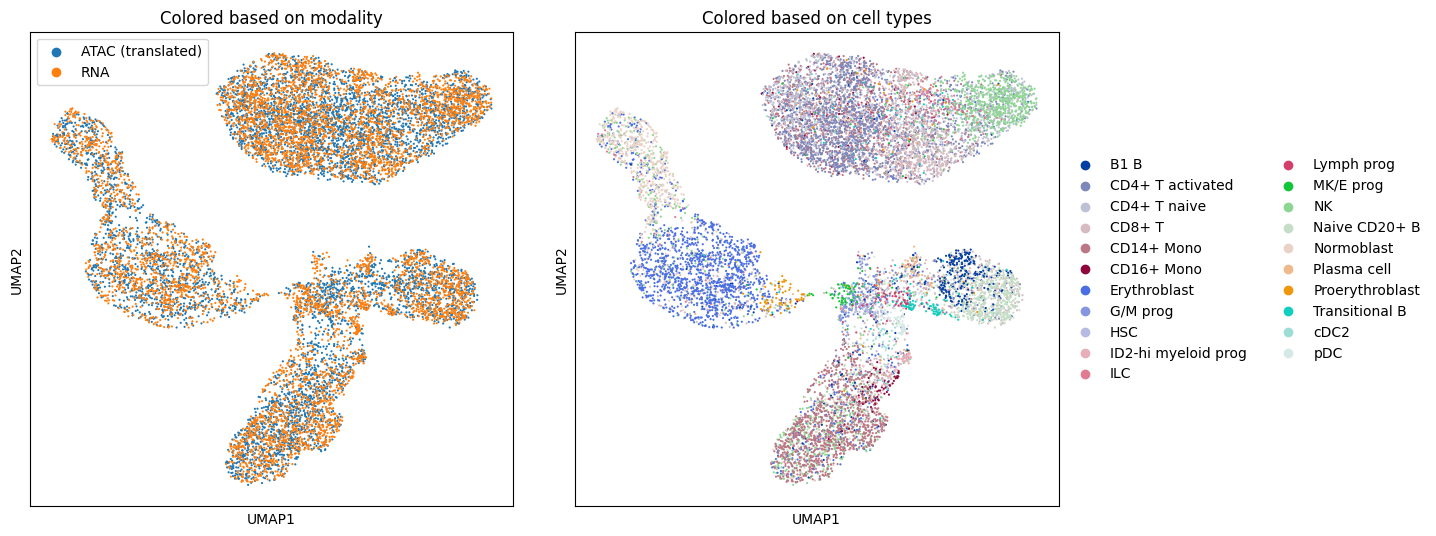

In [14]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[0,...], target_red), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [15]:
import scipy
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [16]:
import scipy 
foscttm(gex_predicted[0,...], target_red)

0.4392

In [17]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_red, seed=i)[0][0,...]

In [18]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [19]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

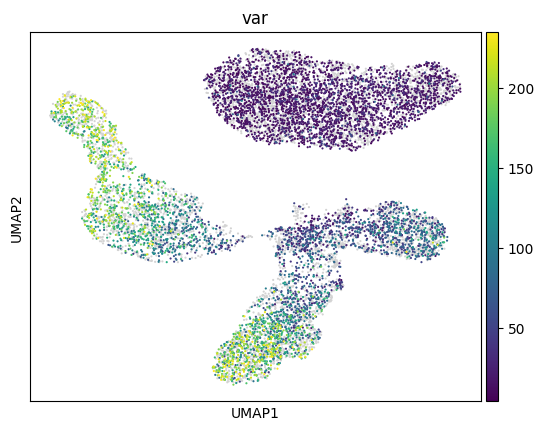

In [20]:
sc.pl.umap(adata, color="var", vmax="p99")

In [21]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,68.174630
CD4+ T activated,19.936370
CD4+ T naive,16.978638
CD8+ T,80.887472
CD14+ Mono,12.914489
CD16+ Mono,18.736673
Erythroblast,137.006989
G/M prog,21.474176
HSC,19.422918


In [32]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,83.601758
CD4+ T activated,19.568209
CD4+ T naive,19.001598
CD8+ T,77.620642
CD14+ Mono,11.951774
CD16+ Mono,12.951762
Erythroblast,131.598336
G/M prog,28.517488
HSC,22.957683


In [33]:
sc.tl.dendrogram(adata, groupby="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


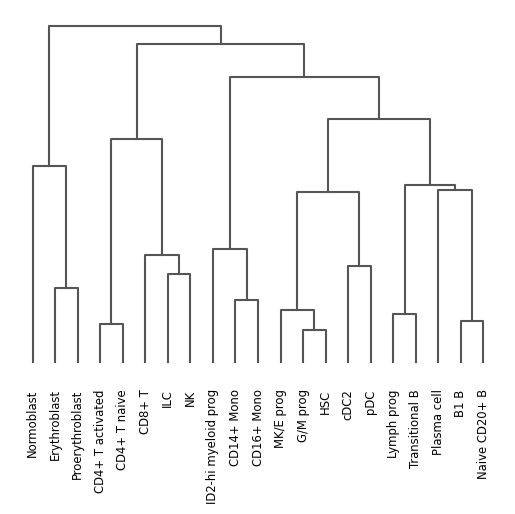

<Axes: >

In [35]:
sc.pl.dendrogram(adata, groupby="cell_type")

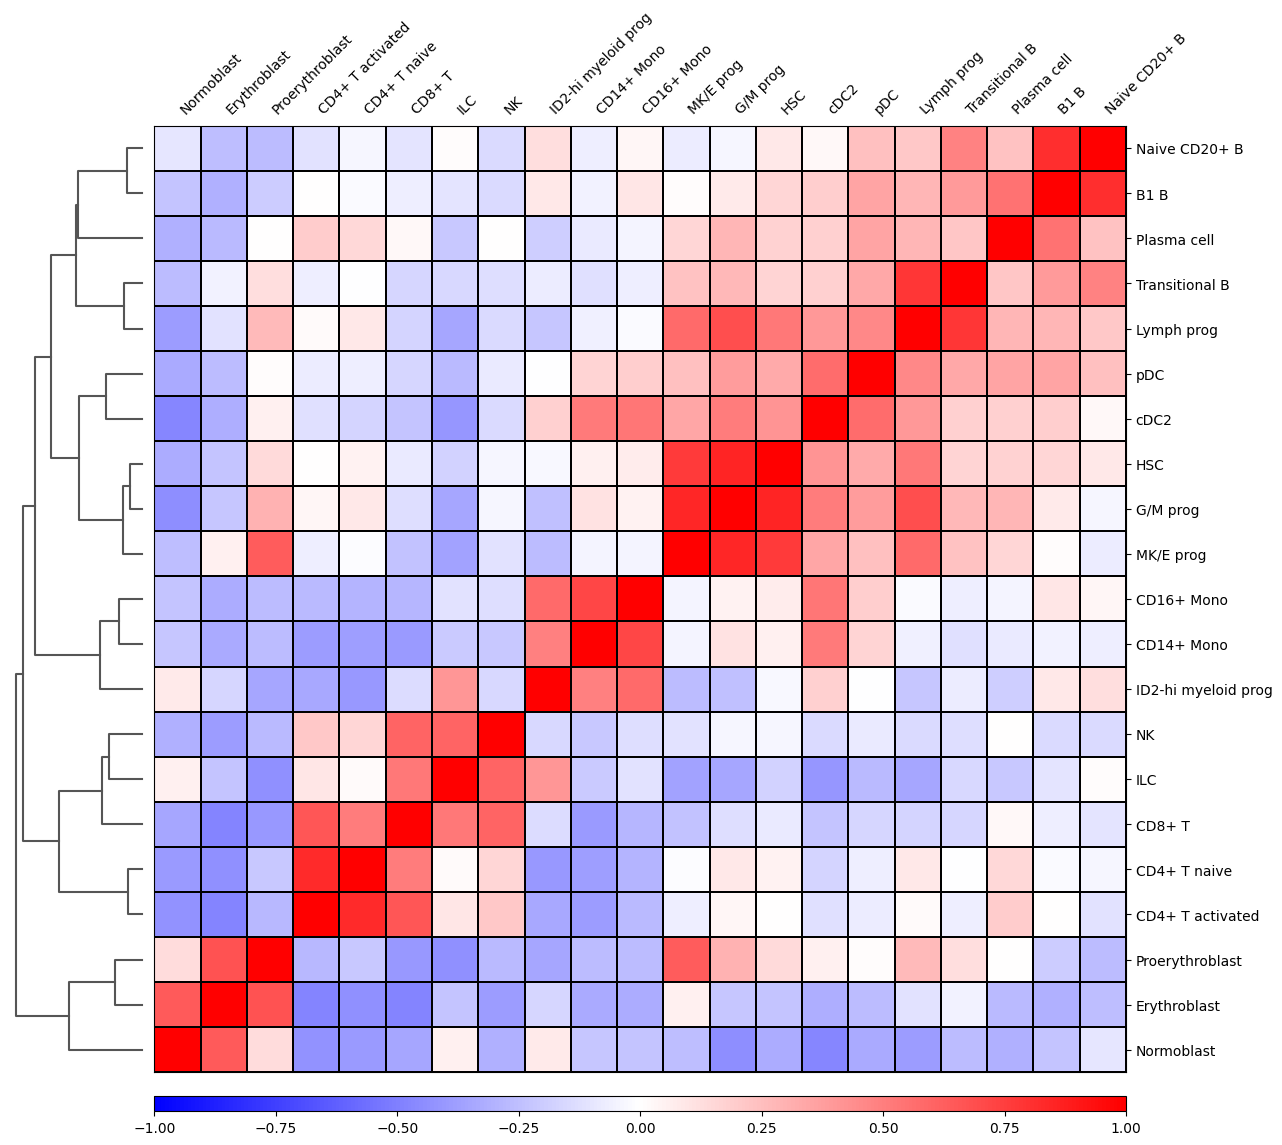

In [37]:
sc.pl.correlation_matrix(adata, groupby="cell_type")